<a href="https://colab.research.google.com/github/DIAZMILEY/REP-GRUPO13/blob/main/AmazonReviews_NPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Análisis y clasificación de sentimientos de los comentarios y criticas de los usuarios de amazon sobre diferentes peliculas y videos**

## **Librerías implementadas en el análisis**

In [1]:
%%time
import gzip
import json
import string
import os

import nltk # imports the natural language toolkit
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import seaborn as sns
import matplotlib.pyplot as plt
import re
import plotly

from nltk.corpus import stopwords

# tokenizadores
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.tokenize import TweetTokenizer

# lematizador basado en WordNet de nltk
from nltk.stem import WordNetLemmatizer 

# steemer de nltk. Raiz de las palabras
#from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer 

import gensim
from gensim.parsing.preprocessing import STOPWORDS

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import LSTM, SpatialDropout1D, Bidirectional
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from keras.preprocessing.text import Tokenizer

nltk.download('punkt')
nltk.download('stopwords')
# wordnet
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
CPU times: user 3.32 s, sys: 663 ms, total: 3.98 s
Wall time: 6.49 s


## **Conexión a google**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## ** Proceso de cargue de datos**

A continuación se hace el cargue de los comentarios de diversas peliculas y videos con su respectiva calificación

In [3]:
%%time
instant_video = pd.read_json("/content/gdrive/MyDrive/Diplomado de Inteligencia artificial y deeplearning Unal/Ejemplo NPL/NPL - Amazon/reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')
movies_tv = next(pd.read_json("/content/gdrive/MyDrive/Diplomado de Inteligencia artificial y deeplearning Unal/Ejemplo NPL/NPL - Amazon/reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=500000))

CPU times: user 29.1 s, sys: 11.1 s, total: 40.3 s
Wall time: 44 s


In [4]:
amazon_data = movies_tv.append(instant_video)

## **Base de datos de peliculas y videos de amazon**

In [5]:
print(len(amazon_data))
print(amazon_data.head(5))

537126
       reviewerID        asin  ... unixReviewTime   reviewTime
0   ADZPIG9QOCDG5  0005019281  ...     1203984000  02 26, 2008
1  A35947ZP82G7JH  0005019281  ...     1388361600  12 30, 2013
2  A3UORV8A9D5L2E  0005019281  ...     1388361600  12 30, 2013
3  A1VKW06X1O2X7V  0005019281  ...     1202860800  02 13, 2008
4  A3R27T4HADWFFJ  0005019281  ...     1387670400  12 22, 2013

[5 rows x 9 columns]


In [6]:
amazon_data.shape

(537126, 9)

In [7]:
amazon_data['datetime'] = pd.to_datetime(amazon_data['reviewTime'], format="%m %d, %Y")
amazon_data = amazon_data.drop(columns = ['reviewerID', 'asin', 'reviewTime'])
amazon_data.head(5)

,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26
1,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30
2,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30
3,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13
4,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22


## **Descripción de los datos**

In [8]:
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size

6.0
4.0


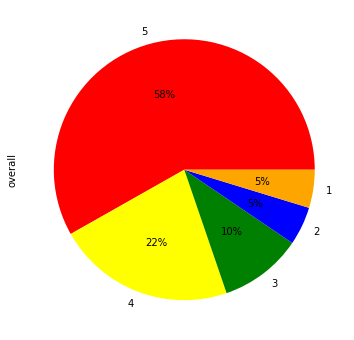

In [9]:
amazon_data.overall.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green","blue","orange"])

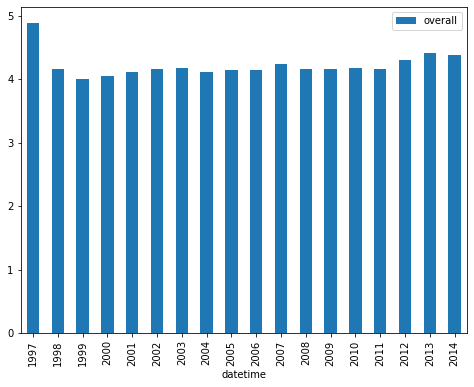

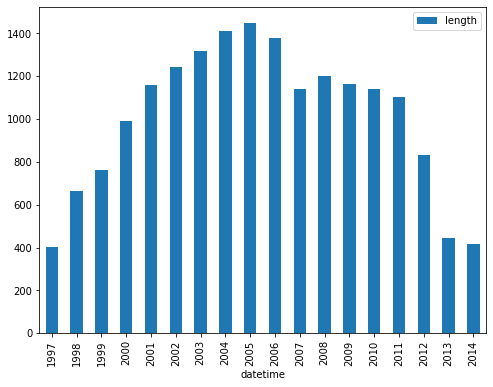

In [10]:
amazon_data.groupby(amazon_data.datetime.dt.year)['overall'].mean().to_frame().plot(kind="bar")

amazon_data['length'] = amazon_data['reviewText'].apply(len)
amazon_data.groupby(amazon_data.datetime.dt.year)['length'].mean().to_frame().plot(kind="bar")

Busqueda de las frecuencias de las palabras de forma general en todos los comentarios

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime

amazon_data = amazon_data.head(len(amazon_data))

def get_top_n_words(corpus, n=1, k=1):
    t1 = datetime.now()
    vec = CountVectorizer(ngram_range=(k, k), stop_words="english")
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

movie 668579
film 584448
like 259424
great 237119
good 236797
just 220199
quot 204832
time 203972
story 186832
dvd 151290
really 146130
love 145152
best 139589
movies 129321
watch 115320
films 112109
way 109195
don 105552
people 105214
life 100565
CPU times: user 1min 3s, sys: 690 ms, total: 1min 4s
Wall time: 1min 4s


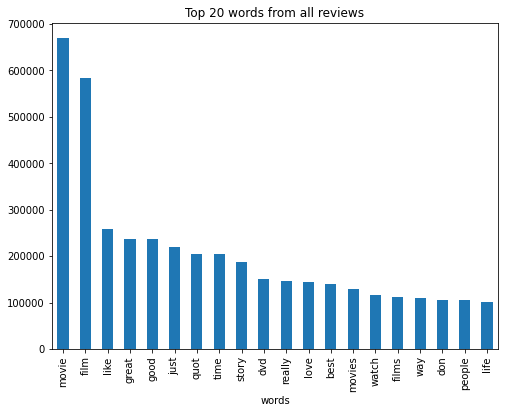

In [12]:
%%time
# All reviews
common_words = get_top_n_words(amazon_data["reviewText"], 20, 1)
for word, freq in common_words:
    print(word, freq)
    
tabla = pd.DataFrame(common_words, columns=["words", "count"])
tabla.groupby("words").sum()["count"].sort_values(ascending=False).plot(
    kind="bar", title="Top 20 de las palabras más frecuentes"
)

## **Preparación y procesamiento de la información para modelamiento y clasificación de sentimientos**

A continuación, se reprocesa la variable de calificaciones 

In [13]:
amazon_data['target_cat'] = pd.Categorical(amazon_data['overall'])
amazon_data.dtypes

reviewerName              object
helpful                   object
reviewText                object
overall                    int64
summary                   object
unixReviewTime             int64
datetime          datetime64[ns]
length                     int64
target_cat              category
dtype: object

In [14]:
print(amazon_data['target_cat'].value_counts())

5    312586
4    118506
3     55067
2     25610
1     25357
Name: target_cat, dtype: int64


## **Proceso de balanceo de las categorías de estudio**

In [15]:
amazon_data_1 = amazon_data[amazon_data['overall']== 1]
amazon_data_2 = amazon_data[amazon_data['overall']== 2 ].sample(len(amazon_data_1))
amazon_data_3 = amazon_data[amazon_data['overall']==3].sample(len(amazon_data_1))
amazon_data_4 = amazon_data[amazon_data['overall']==4].sample(len(amazon_data_1))
amazon_data_5 = amazon_data[amazon_data['overall']==5].sample(len(amazon_data_1))

## El balanceo de los datos fue definido en función del tamaño de la menor categoría encontrada
print(amazon_data_1.shape)
print(amazon_data_2.shape)
print(amazon_data_3.shape)
print(amazon_data_4.shape)
print(amazon_data_5.shape)

(25357, 9)
(25357, 9)
(25357, 9)
(25357, 9)
(25357, 9)


In [16]:
amazon_data_12 = amazon_data_1.append(amazon_data_2)
amazon_data_123 =amazon_data_12.append(amazon_data_3)
amazon_data_1234 = amazon_data_123.append(amazon_data_4)
amazon_data_bal = amazon_data_1234.append(amazon_data_5)

amazon_data_bal["index"] = range(0,len(amazon_data_bal))

amazon_data_bal.shape

(126785, 10)

## **Ajuste de las calificaciones en sentimientos positivos y negativos**

In [17]:
amazon_data_bal['target'] = np.where(amazon_data_bal.overall < 3, '0', 
                       np.where(amazon_data_bal.overall > 3, '1', '3'))

amazon_data_bal = amazon_data_bal[(amazon_data_bal["target"])!= "3"]

In [18]:
print(amazon_data_bal['target'].value_counts())
amazon_data_bal.set_index("index", inplace=True)
amazon_data_bal.head()

1    50714
0    50714
Name: target, dtype: int64


,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,datetime,length,target_cat,target
index,,,,,,,,,,
0,"sharp eye klf ""klf""","[13, 23]","The acting was good, the story was correct, bu...",1,Nakedness not necessary!,1298851200,2011-02-28,337,1,0
1,L Salisbury,"[3, 5]",This is so lame! The songs are terrible! The v...,1,Worst Christmas special ever!,976233600,2000-12-08,295,1,0
2,Mrs Pink,"[3, 5]",This is with out a doubt is one of the worst C...,1,Frosty returns,975888000,2000-12-04,564,1,0
3,Philip D. Parshall,"[2, 3]",Narration is OK but the story is weak and the ...,1,1960's Classic Comes To This?,1196553600,2007-12-02,508,1,0
4,L. M Young,"[35, 40]",If you love the Rankin-Bass version of this cl...,1,Not The Aaron I Remember,1097366400,2004-10-10,1557,1,0


In [19]:
## Categorización de la variable target compuesta por 0 y 1
amazon_data_label = amazon_data_bal.target.factorize()
print(amazon_data_label)

(array([0, 0, 0, ..., 1, 1, 1]), Index(['0', '1'], dtype='object'))


## **Depuración de los textos**

In [20]:
## Ejemplo de como viene el texto que se requiere analizar
amazon_data_bal['reviewText'][2]

"This is with out a doubt is one of the worst Christmas movies I have ever seen!  My daughter liked it because it had a snowman in it, but that's the only reason.  The movie is filled with overdone, unrealistic, trite political issues of the 90's.  It was too complicated for a small child to follow and there was barely even a plot.  Only get this if your child is in love with snowmen and you've exhausted all other viewing avenues.  There was nothing original in this movie that wasn't absurd.  The original Frosty is so wonderfully simple, buy that one instead."

## **Función de depuración de los textos**

In [21]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # digitos
    sentence = re.sub('\d+', ' ', sentence)

    # paréntesis
    sentence = re.sub('[()]', ' ', sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # This removes words of up to 3 characters 
    #sentence = re.sub(r'\b\w{1,3}\b', '',sentence)

    return sentence

In [22]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

A continuación se aplica la función de depuración para los textos en general de la base de datos de interés, es necesario precisar que se esta trabajando sobre el conjunto de datos balanceado de amazon

In [23]:
%%time
X = [] ## Nueva lista en donde se almacenara la información reprocesada
sentences = list(amazon_data_bal['reviewText'])
for sen in sentences:
    X.append(preprocess_text(sen))

CPU times: user 15.9 s, sys: 23 ms, total: 15.9 s
Wall time: 15.9 s


In [24]:
X[2]

'This is with out doubt is one of the worst Christmas movies have ever seen My daughter liked it because it had snowman in it but that the only reason The movie is filled with overdone unrealistic trite political issues of the It was too complicated for small child to follow and there was barely even plot Only get this if your child is in love with snowmen and you ve exhausted all other viewing avenues There was nothing original in this movie that wasn absurd The original Frosty is so wonderfully simple buy that one instead '

## **Preparación de los datos para entrenar el modelo**

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, amazon_data_label[0], test_size=0.30, random_state=2906)

In [26]:
pr = 128 
a = (len(X_train)/pr) 
ntrain = round(pr*(a-1)) 

b = (len(X_test)/pr) 
ntest = round(pr*(b-1)) 

In [27]:
X_train = X_train[0:ntrain] 
X_test = X_test[0:ntest] 
y_train = y_train[0:ntrain] 
y_test = y_test[0:ntest]

In [28]:
%%time
tokenizer = Tokenizer(num_words=40000)
tokenizer.fit_on_texts(X_train)
#tokenizer.fit_on_texts(X_test)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

CPU times: user 21.1 s, sys: 372 ms, total: 21.5 s
Wall time: 21.5 s


In [29]:
print(X_train[1])

[8, 136, 3, 1168, 347, 27, 1282, 5, 23, 3, 50, 1793, 2984, 85, 3, 1, 17986, 2, 4107, 240, 27, 886, 6958, 12, 1, 11450, 1463, 6958, 63, 2506, 7, 1, 1846, 362, 3, 1168, 2, 14230, 22, 215, 7, 8, 16, 136, 7815, 69, 34051, 8, 362, 10, 19, 114, 2427, 4, 5179, 139, 35, 21, 106, 1197, 7, 134, 7, 8, 16, 136, 10, 564, 1, 578, 3, 7341, 5346, 2775, 2, 2224, 2366, 18373, 21, 12021, 120, 2, 7341, 5, 1, 73, 4, 719, 1650, 4, 1, 1463, 4400, 7394, 1, 13, 661, 14, 883, 6433, 78, 1, 14447, 28, 1, 13532, 461, 3, 7, 1569, 118, 611, 21628, 231, 27, 2052, 6332, 2, 33, 80, 261, 2224, 369, 1143, 22, 5443, 10, 1, 3622, 2165, 1168, 758, 4, 25, 1, 60, 3826, 3, 1, 20973, 2, 2808, 9803, 5829, 2407, 43, 349, 3, 1168, 16422, 12202, 1588, 16754, 1168, 16422, 4, 28532, 5596, 118, 1168, 5, 3896, 7341, 1542, 12754, 27, 1168, 1597, 2, 42, 369, 611, 6470, 936, 5919, 2269, 4076, 3107, 10340, 42, 332, 17540, 1, 390, 974, 3, 1, 1463, 7, 1, 1530, 392, 8, 13, 1139, 3, 1168, 10, 1, 8653, 1183, 5135, 207, 6958, 2, 18373, 2224, 250

In [30]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 500

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [31]:
print("Tamaño del vocabulario: "+ str(len(tokenizer.word_index)))
print(X_train[0])

Tamaño del vocabulario: 121217
[    8   373     5    41     2   375  4306   615     1   531     3     1
    16     4   311   268     2   112    19  1517     1   443  4218     3
     1   134    39    50  4288    17     1    13   237   133    39   718
   273   288    17 16421 12020     2    30 21626   311   268   900    77
    19   111     9     8    16    38    76  1879     7   104    94     6
     5  1495     9   181    67  5086    17   311   268    59    90    23
    15   483     3  8651   112    24    97     7     1   810     3   380
 28530  2604   236    97    60   258   200     1   443  2501     2   432
   127     2  8429    97    12    64     1 21627     5    19   469    15
    19    57   350     1    16    38  2314  2260  1176    14    40     3
   439  1297     6    19     9    18    81    72   329     4   337    43
   116   147    15     8    16    11   260     4   311   268    31    30
   140   411   537     2    11    19  5031    51    28    26   837  4151
    21    19   837  

### **Definición de uso de la TPU**

In [32]:
%tensorflow_version 2.x   # Para garantizar que la versión 2.x sea importada
import tensorflow as tf
print('Versión de TensorFlow: ' + tf.__version__)

tf.random.set_seed(200)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])  # Detectar TPU
  print('TPU encontrada ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: TPU no encontrada!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x   # Para garantizar que la versión 2.x sea importada`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Versión de TensorFlow: 2.4.1
TPU encontrada  ['10.29.204.10:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.29.204.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.29.204.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# **Arquitectura preliminar de la red neuronal para la clasificación de sentimientos**

In [33]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

## **Modelo implementando Glove**

In [34]:
!wget http://nlp.stanford.edu/data/glove.6B.zip  
!unzip glove.6B.zip 

--2021-05-03 09:40:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-03 09:40:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-03 09:40:12--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [35]:
embeddings_dictionary = dict()
with open('glove.6B.300d.txt', "r") as file:     
    for line in file:         
       tokens = line.split()      
       word = tokens[0]         
       vector_dimensions = np.array(tokens[1:], dtype=np.float32) 
       if vector_dimensions.shape[0] == 300:    
           embeddings_dictionary[word] = vector_dimensions 
       else:      
           print("There was an issue with " + word) 
# let's check the vocabulary size 
print("Dictionary Size: ", len(embeddings_dictionary)) 

Dictionary Size:  400000


In [36]:
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## **Arquitectura de la red implementando Glove**

In [45]:
with tpu_strategy.scope():
  embedding_vector_length = 300

  model_glove=Sequential()

  embedding_layer=Embedding(vocab_size,embedding_vector_length,
                            weights=[embedding_matrix],
                            input_length=300,trainable=False)

  model_glove.add(embedding_layer)
  model_glove.add(SpatialDropout1D(0.5))
  model_glove.add(LSTM(64, dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
  model_glove.add(tf.keras.layers.LSTM(128,return_sequences=True))
  model_glove.add(Dropout(0.5))
  model_glove.add(tf.keras.layers.LSTM(64))
  model_glove.add(Dropout(0.5))
  model_glove.add(tf.keras.layers.Dense(32, activation='relu'))

  model_glove.add(Dense(1, activation='sigmoid'))

  model_glove.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  

  print(model_glove.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          36365400  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 300, 300)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 300, 64)           93440     
_________________________________________________________________
lstm_7 (LSTM)                (None, 300, 128)          98816     
_________________________________________________________________
dropout_4 (Dropout)          (None, 300, 128)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [46]:
def entrenamiento_tpu():
  history_glove = model_glove.fit(X_train,y_train,
                                  validation_split=0.2, 
                                  batch_size=128, epochs=60, verbose=1)
  
  return history_glove

In [47]:
history_glove = entrenamiento_tpu()

Epoch 1/60


443/443 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5001WARNING:tensorflow:Model was constructed with shape (None, 300) for input KerasTensor(type_spec=TensorSpec(shape=(None, 300), dtype=tf.float32, name='embedding_2_input'), name='embedding_2_input', description="created by layer 'embedding_2_input'"), but it was called on an input with incompatible shape (None, 500).


443/443 [==============================] - 48s 87ms/step - loss: 0.6935 - accuracy: 0.5001 - val_loss: 0.6924 - val_accuracy: 0.5050
Epoch 2/60
443/443 [==============================] - 32s 73ms/step - loss: 0.6919 - accuracy: 0.5058 - val_loss: 0.6890 - val_accuracy: 0.5093
Epoch 3/60
443/443 [==============================] - 33s 73ms/step - loss: 0.6905 - accuracy: 0.5110 - val_loss: 0.6880 - val_accuracy: 0.5084
Epoch 4/60
443/443 [==============================] - 32s 73ms/step - loss: 0.6977 - accuracy: 0.5033 - val_loss: 0.6933 - val_accuracy: 0.4940
Epoch 5/60
443/443 [==============================] - 33s 74ms/step - loss: 0.6934 - accuracy: 0.4983 - val_loss: 0.6828 - val_accuracy: 0.6782
Epoch 6/60
443/443 [==============================] - 33s 73ms/step - loss: 0.6786 - accuracy: 0.5749 - val_loss: 0.6589 - val_accuracy: 0.5901
Epoch 7/60
443/443 [==============================] - 33s 74ms/step - loss: 0.6566 - accuracy: 0.6124 - val_loss: 0.6264 - val_accuracy: 0.6562
Epo

### **Verificación de las metricas del modelo establecido**

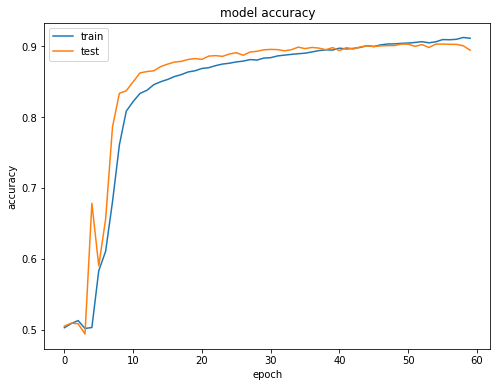

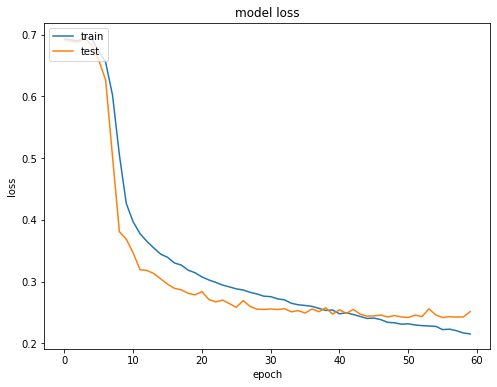

In [50]:
plt.plot(history_glove.history['accuracy'])
plt.plot(history_glove.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.savefig('accuracy.jpg', bbox_inches='tight', dpi=150)
plt.show()

plt.plot(history_glove.history['loss'])
plt.plot(history_glove.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.savefig('loss.jpg', bbox_inches='tight', dpi=150)
plt.show()

In [51]:
## Guardado del modelo
model_glove.save('/content/gdrive/MyDrive/Diplomado de Inteligencia artificial y deeplearning Unal/model_Glove_final_0.90.h5')

In [ ]:
## Carga del modelo guardado
new_model = keras.models.load_model('/content/gdrive/MyDrive/Diplomado de Inteligencia artificial y deeplearning Unal/model_Glove1_0.90.h5')

### **Prueba del modelo en datos que desconoce**

In [52]:
score = model_glove.evaluate(X_test, y_test, verbose=1)

print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

947/947 [==============================] - 29s 30ms/step - loss: 0.2502 - accuracy: 0.8967
Test Loss: 0.2501554489135742
Test Accuracy: 0.8967360854148865


In [53]:
model_glove.predict(X_test)

array([[0.99171793],
       [0.00670978],
       [0.96261424],
       ...,
       [0.987929  ],
       [0.96217877],
       [0.97740376]], dtype=float32)

### **Predicción y clasificación del sentimiento**

In [60]:
## Ejemplo de predicción y clasificación de un sentimiento negativo
test_word = []

# Ejemplo para un sentimiento negativo
test_word.append("I consider the film to be boring and in several sections really bad, I do not recommend it, do not waste your time")

tw = tokenizer.texts_to_sequences(test_word)
tw = pad_sequences(tw,maxlen=500)
tw

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [61]:
prediction = model_glove.predict(tw)
prediction

array([[0.017288]], dtype=float32)

In [62]:
if prediction <0.5:
  print("Sentimiento Negativo") 
else:
  print("Sentimiento Positivo")

Sentimiento Negativo


In [63]:
## Ejemplo de predicción y clasificación de un sentimiento positivo
test_word = []

# Ejemplo para un sentimiento positivo
test_word.append("What a good movie, highly recommended, I found it entertaining and fun")

tw = tokenizer.texts_to_sequences(test_word)
tw = pad_sequences(tw,maxlen=500)
tw

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [64]:
prediction = model_glove.predict(tw)
prediction

array([[0.98435074]], dtype=float32)

In [65]:
if prediction <0.5:
  print("Sentimiento Negativo") 
else:
  print("Sentimiento Positivo")

Sentimiento Positivo


### **Matriz de confusión**

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

predict = model_glove.predict(X_test)
y_pred = [1 * (x[0]>=0.5) for x in predict]

print('Confusion Matrix:\n')
print(confusion_matrix(y_test, y_pred),'\n')

print(classification_report(y_test, y_pred))

Confusion Matrix:

[[12910  2200]
 [  929 14262]] 

              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89     15110
         1.0       0.87      0.94      0.90     15191

    accuracy                           0.90     30301
   macro avg       0.90      0.90      0.90     30301
weighted avg       0.90      0.90      0.90     30301



## **Verificación de las palabras que definen la clase de sentimiento entregado en los comentarios de los videos y las peliculas de amazon**

In [68]:
# Instalación de la librería vadersentiment
!pip install vaderSentiment

     |████████████████████████████████| 133kB 6.6MB/s 


### **Proceso de busqueda de palabras y frases que definen los sentimientos positivos y negativos**

In [ ]:
#from textblob import textblob 

from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



### **Palabras que definen los sentimientos positivos de los comentarios de las peliculas y videos de amazon**

movie 62466
film 58694
good 24347
like 24185
great 23770
quot 20514
just 19702
time 19593
story 18554
dvd 14675
love 13901
best 13763
really 13761
movies 12040
films 11027
watch 10706
way 10585
life 10242
people 9885
don 9462
CPU times: user 9.25 s, sys: 358 ms, total: 9.61 s
Wall time: 9.49 s


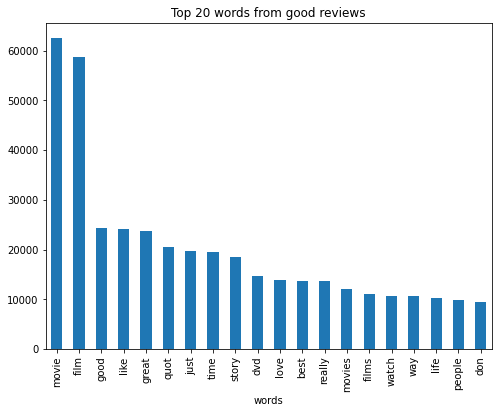

In [74]:
%%time
# Positive reviews
good_indices = amazon_data_bal["overall"] > 3.1
good_reviews = amazon_data_bal[good_indices]
bad_indices = amazon_data_bal["overall"] < 2.1
bad_reviews = amazon_data_bal[bad_indices]

common_words = get_top_n_words(good_reviews["reviewText"], 20)
for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns=["words", 'count'])
df.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words from good reviews'
)

### **Palabras que definen los sentimientos negativos de los comentarios de las peliculas y videos en amazon**

movie 76309
film 56209
like 33455
just 31707
good 22646
quot 22241
time 18698
really 17271
bad 17136
story 16003
don 15860
dvd 14340
people 12743
movies 12475
better 12244
make 12195
way 11650
did 11597
great 11381
watch 10797
CPU times: user 7.16 s, sys: 28.6 ms, total: 7.19 s
Wall time: 7.2 s


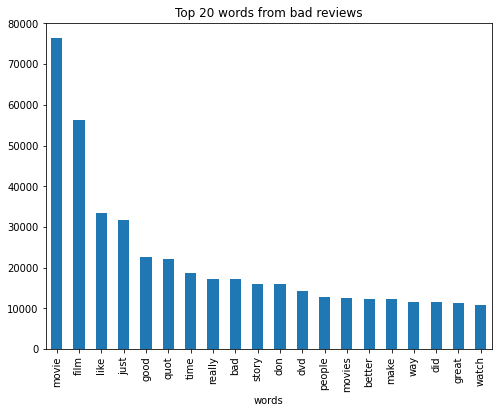

In [75]:
%%time

# Negative reviews
common_words = get_top_n_words(bad_reviews['reviewText'], 20)
for word, freq in common_words:
    print(word, freq)
df = pd.DataFrame(common_words, columns=['words', 'count'])
df.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words from bad reviews'
)

## **Extracción de las palabras claves que definen el sentimiento del comentario de las peliculas**

In [69]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer=SentimentIntensityAnalyzer()
sent=analyzer.polarity_scores(X[0])
print(X[0])
print(sent)

The acting was good the story was correct but naked backsides was not necessary Also the Potiphers wife did not need to be so very seductive of naked Joseph Not Christian movie felt that even though it was probably portrayed truthfully Christans do not need to see so explicit scene This should be rated PG at least 
{'neg': 0.0, 'neu': 0.905, 'pos': 0.095, 'compound': 0.7003}


In [71]:
from textblob import TextBlob

def word_polarity(test_subset):
    pos_word_list=[]
    neu_word_list=[]
    neg_word_list=[]

    for word in test_subset:               
        testimonial = TextBlob(word)
        if testimonial.sentiment.polarity >= 0.5:
            pos_word_list.append(word)
        elif testimonial.sentiment.polarity <= -0.5:
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)

    print('Positive :',pos_word_list)        
    print('Neutral :',neu_word_list)    
    print('Negative :',neg_word_list)   

### **Palabras que definen un sentimiento positivo**

In [90]:
from nltk.tokenize import sent_tokenize, word_tokenize
i=100000
print("La clasificación de esta pelicula fue: ",str(amazon_data_bal["target"][i]))
print(sent_tokenize(X[i]))
word_polarity(word_tokenize(X[i]))
sent=analyzer.polarity_scores(X[i])
print(sent)

La clasificación de esta pelicula fue:  1
['The musical numbers were great The sets were totally authentic you really believe you are looking at early th century St Louis Marjorie Main and Judy Garland stole the show Tootie was annoying Except for her character the film was delight']
Positive : ['great', 'authentic']
Neutral : ['The', 'musical', 'numbers', 'were', 'The', 'sets', 'were', 'totally', 'you', 'really', 'believe', 'you', 'are', 'looking', 'at', 'early', 'th', 'century', 'St', 'Louis', 'Marjorie', 'Main', 'and', 'Judy', 'Garland', 'stole', 'the', 'show', 'Tootie', 'was', 'Except', 'for', 'her', 'character', 'the', 'film', 'was', 'delight']
Negative : ['annoying']
{'neg': 0.055, 'neu': 0.78, 'pos': 0.164, 'compound': 0.743}


### **Palabras que definen un sentimiento negativo**

In [80]:
from nltk.tokenize import sent_tokenize, word_tokenize
i=1
print("La clasificación de esta pelicula fue: ",str(amazon_data_bal["target"][i]))
print(sent_tokenize(X[i]))
word_polarity(word_tokenize(X[i]))
sent=analyzer.polarity_scores(X[i])
print(sent)

La calificación de esta pelicula fue:  0
['This is so lame The songs are terrible The villan is ripoff of Mr Burns from The Simpsons while the kids look like they re on loan from Charlie Brown show But the biggest lowpoint is the Politically Correct ranting Too bad CBS insists on running this back to back with the classic']
Positive : []
Neutral : ['This', 'is', 'so', 'The', 'songs', 'are', 'The', 'villan', 'is', 'ripoff', 'of', 'Mr', 'Burns', 'from', 'The', 'Simpsons', 'while', 'the', 'kids', 'look', 'like', 'they', 're', 'on', 'loan', 'from', 'Charlie', 'Brown', 'show', 'But', 'the', 'biggest', 'lowpoint', 'is', 'the', 'Politically', 'Correct', 'ranting', 'Too', 'CBS', 'insists', 'on', 'running', 'this', 'back', 'to', 'back', 'with', 'the', 'classic']
Negative : ['lame', 'terrible', 'bad']
{'neg': 0.152, 'neu': 0.819, 'pos': 0.029, 'compound': -0.8104}
